# Badmintion court Detection and Players tracking

## Libraries Used
The following libraries are utilized in the notebook to accomplish the tasks:
- ```cv2```: OpenCV library for computer vision tasks, such as image and video processing
- ```os```: Standard Python library to interact with the operating system, used for file and directory operations
- ```re```: Standard Python library for regular expression operations, used for string searching and manipulation
- ```numpy```: A library for numerical computing in Python, used for array operations and mathematical computations
- ```matplotlib.pyplot```: A plotting library in Python, used for visualizing images and results
- ```PIL.Image```: Python Imaging Library (PIL) for opening, manipulating, and saving many different image file formats
- `ultralytics`: A package that contains the YOLO (You Only Look Once) object detection model.

The below command installs the latest version:

`
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install Pillow
!pip install ultralytics
`

## Implementation Details

The tasks are solved in the following manner:

### Task 1: Color Segmentation   
The code performs color segmentation to identify the green color of the badminton court. It converts images to the HSV color space and creates a mask to filter out the green color using a predefined range for green in HSV

    
### Task 2: Court Line Detection
After segmenting the court, the code likely uses techniques such as edge detection or Hough line transforms to detect the lines of the badminton court. However, the specific implementation details for this task are not provided in the search results.

reference: https://github.com/ChaosAdmStudent/qualitative-badminton-player-analysis/blob/main/1)%20Court%20Line%20Detection.ipynb
    
### Task 3: Players Detection
The code detects players on the court. This could involve using background subtraction methods or pre-trained models to identify and locate players
    
      
### Task 4: Tracking Players with YOLOv8 and Custom Tracker
The code uses YOLOv8, an object detection model, to detect players in each frame of the video. A custom-implemented tracker is then used to track the movement of players across frames. The tracker might use techniques such as centroid tracking or more advanced methods like Kalman filters or SORT (Simple Online and Realtime Tracking)

## Import essitential packages

In [230]:
import  cv2
import  os
import  re
import  numpy as np
import  random

from    matplotlib  import pyplot as plt



## Setting some dirtectory variables

In [231]:
SOURCE_DIR = './Dataset/'
SOURCE_SINGLE_DIR = os.path.join(SOURCE_DIR, 'SINGLEframes/')
SOURCE_DOUBLE_DIR = os.path.join(SOURCE_DIR, 'DOUBLEframes/')

RESULTS_DIR = './results/'
RESULTS_SINGLE_DIR = os.path.join(RESULTS_DIR, 'single/')
RESULTS_DOUBLE_DIR = os.path.join(RESULTS_DIR, 'double/')

WEIGHTS_DIR = './weights/'

if not os.path.exists(RESULTS_SINGLE_DIR):
    os.makedirs(RESULTS_SINGLE_DIR)
    
if not os.path.exists(RESULTS_DOUBLE_DIR):
    os.makedirs(RESULTS_DOUBLE_DIR)
    
if not os.path.exists(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)

In [232]:
# !wget -P $WEIGHTS_DIR https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8n.pt


In [233]:
# MODEL_WEIGHT_PATH = os.path.join(WEIGHTS_DIR, 'yolov8n.pt')

## Prework: Loading the data and choose
    
The **load_images_from_folder** function is designed to load images from a specified folder ```SOURCE_DIR``` and filter them based on the percentage of green pixels, which is indicative of the presence of a badminton court.
    


In [234]:
def load_images_from_folder(folder, threshold):
    images = []

    for filename in [file for file in os.listdir(folder) if file.endswith('.png')]:
        print(filename)
    
    for filename in [file for file in os.listdir(folder) if file.endswith('.png')]:
        print(os.path.join(folder,filename))
        img = cv2.imread(os.path.join(folder, filename))
        
        if img is not None:
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

            lower_green = np.array([36, 0, 0])
            upper_green = np.array([86, 255, 255])
            
            mask_img = cv2.inRange(hsv, lower_green, upper_green)

            green_percentage = (np.count_nonzero(mask_img) / np.size(mask_img)) * 100
            print(green_percentage)
            if green_percentage > (threshold - 4):
#                 print(f"Image {filename} has {green_percentage:.2f}% green pixels, keeping it.")
                # Optionally, you can save the result image
                images.append((filename, img))
            else:
                print(f"Image {filename} has {green_percentage:.2f}% green pixels, discarding it.")
                
    # images.sort(key=lambda x: int(re.search(r'frame(\d+)-(SINGLE|DOUBLE)', x[0]).group(1)))

    return images

### (i) SINGLE

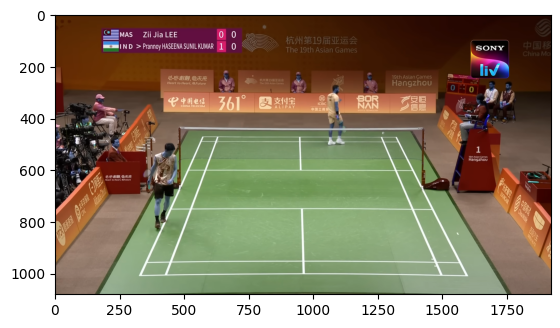

In [235]:
f_sng = os.path.join(SOURCE_SINGLE_DIR, 'frame1.png')

img_sng = cv2.imread(f_sng)
plt.imshow(img_sng)

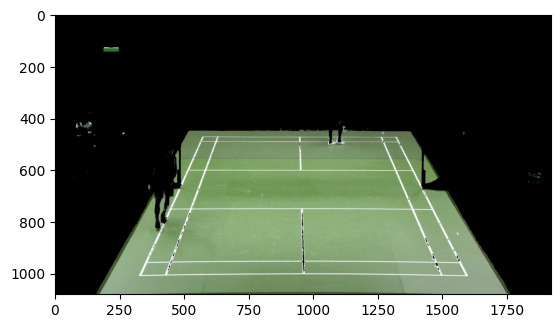

In [236]:
hsv = cv2.cvtColor(img_sng, cv2.COLOR_BGR2HSV)

lower_green = np.array([36, 8, 10])
upper_green = np.array([86, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)

res = cv2.bitwise_and(img_sng, img_sng, mask= mask)

plt.imshow(res)

get the percentage of the court in the image to become the threshold to filter the image

In [237]:
threshold = round(np.count_nonzero(mask) / np.size(mask) * 100, 1)
print('the percentage of the green: ', threshold)

the percentage of the green:  36.6


In [238]:
images_single = load_images_from_folder(SOURCE_SINGLE_DIR, threshold)


frame1.png
./Dataset/SINGLEframes/frame1.png
36.83588927469136


## Task1: color segamentation

`get_mask()`
This function takes an image as input and processes it to create a mask that isolates a specific color range, in this case, green.

`find_largest_contour()`
This function takes a mask and the original image as inputs and identifies the largest contour within the mask. 

In [239]:
def get_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_green = np.array([36, 0, 0])
    upper_green = np.array([86, 255, 255])
    
    mask = cv2.inRange(hsv, lower_green, upper_green)
    
    return mask

In [240]:
def find_largest_contour(mask, image):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = max(contours, key=cv2.contourArea)

    largest_contour_mask = np.zeros_like(mask)

    cv2.drawContours(largest_contour_mask, [largest_contour], -1, color=255, thickness=cv2.FILLED)
    
    return largest_contour_mask, largest_contour

### (i) SINGLE

In [241]:
print(images_single)
img_sng = images_single[0][1]

mask = get_mask(res)

[('frame1.png', array([[[ 84,  40,   3],
        [ 84,  40,   3],
        [ 84,  40,   3],
        ...,
        [ 32,   6,   2],
        [ 32,   6,   2],
        [ 32,   6,   2]],

       [[ 84,  40,   3],
        [ 84,  40,   3],
        [ 84,  40,   3],
        ...,
        [ 32,   6,   2],
        [ 32,   6,   2],
        [ 32,   6,   2]],

       [[ 84,  40,   3],
        [ 84,  40,   3],
        [ 84,  40,   3],
        ...,
        [ 32,   6,   2],
        [ 32,   6,   2],
        [ 32,   6,   2]],

       ...,

       [[128, 106,  92],
        [128, 106,  92],
        [127, 105,  91],
        ...,
        [127, 102,  89],
        [127, 102,  89],
        [127, 102,  89]],

       [[130, 109,  95],
        [129, 107,  93],
        [129, 107,  93],
        ...,
        [127, 102,  89],
        [127, 102,  89],
        [127, 102,  89]],

       [[132, 110,  96],
        [130, 109,  95],
        [130, 109,  95],
        ...,
        [127, 102,  89],
        [127, 102,  89],
        

In [242]:
mask_sng, contour_sng = find_largest_contour(mask, res)

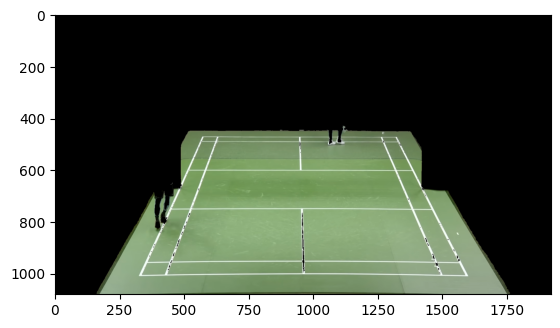

In [243]:
res_sng = cv2.bitwise_and(res,res, mask=mask_sng)

plt.imshow(res_sng)

## Task2: Court detection

The provided code snippet contains two functions, `hough_line` and `single_image_preprocess`, which are part of a computer vision pipeline to process images, particularly for detecting lines and preprocessing images in the context of a badminton game analysis.

#### Function: `hough_line`

The `hough_line` function is designed to detect lines in an image using the Hough Line Transform, a feature extraction technique used in image analysis. The function takes two arguments: `img`, which is the input image, and `people_count`, which is the number of people detected in the image and affects the line detection parameters.


#### Function:`find_centers`
The `find_centers` function is designed to find the intersection points of detected lines in an image, which is a common task in computer vision applications such as lane detection in autonomous driving or grid detection in digital image processing. The function takes two arguments: `lines_list`, which is a list of lists containing line segments, and `nclusters`, which specifies the number of clusters to use in the k-means clustering algorithm.

#### Function:`sort_centers`
The `sort_centers` function is designed to organize a list of center points,obtained from `find_centers`. The function takes a single argument, `centers`, which is an array of points (each point being a pair of x and y coordinates).  

In [244]:
def hough_line(img, people_count):
    
    lower = 50
    upper = 150

    edges = cv2.Canny(img, lower, upper, apertureSize=5) 
    
    cdstP = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    
    if people_count == 2:
        mlg = 255
    else:
        mlg = 75

    linesP = cv2.HoughLinesP(edges, rho=1, theta=np.pi/90, threshold=90, minLineLength=10, maxLineGap=mlg)

    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

    plt.imshow(cdstP)
    
    return edges, linesP, cdstP

In [245]:
def find_centers(lines_list, nclusters):
    
    delta_x = 280
    delta_y = 0.5
    
    ptrs = []
    for lines in lines_list:
        h_lines = []
        v_lines = []
        for line in lines:
            for x1, y1, x2, y2 in line:
                if abs(y2-y1) < delta_y: 
                    h_lines.append(line)
                elif abs(x2-x1) < delta_x: 
                    v_lines.append(line)

        for h_line in h_lines:
#             print(h_line)
            for v_line in v_lines:
#                 print(v_line)
                x1, y1, x2, y2 = h_line[0]
                x3, y3, x4, y4 = v_line[0]


                # Calculate the intersection point
                px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / ((x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))
                py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / ((x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))
                
                ptrs.append((px, py))
    
    
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, _, centers = cv2.kmeans(np.float32(ptrs), nclusters, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    
    return centers

In [246]:
def sort_centers(centers):
    
    
    tolerance = 1

    
    rounded_y = np.round(centers[:, 1] / tolerance) * tolerance

    groups = {}
    for i, y in enumerate(rounded_y):
        if y not in groups:
            groups[y] = []
        groups[y].append(centers[i])

    # Convert groups to list for easier viewing/manipulation
    grouped_points = list(groups.values())

#     for i, group in enumerate(grouped_points):
#         print(f"Group {i+1}: {group}\n")
    sorted_grouped_points = []

    for group in grouped_points:
        # Sort each group by the x-coordinate
        sorted_group = sorted(group, key=lambda x: x[0])
        sorted_grouped_points.append(sorted_group)

    # Sort the groups by the average y-coordinate of each group
    sorted_grouped_points.sort(key=lambda group: np.mean([point[1] for point in group]))

    # Print the sorted groups
#     for i, group in enumerate(sorted_grouped_points):
#         print(f"Sorted Group {i+1}: {group}\n")

    sorted_points = [[arr.astype(np.int32) for arr in sublist] for sublist in sorted_grouped_points]

    return sorted_points

### (i) SINGLE

#### Function: `single_image_preprocess`
The `single_image_preprocess` function preprocesses an image for further analysis. It takes two arguments: `image`, which is the input image, and `mask_sng`, which is a binary mask used to isolate certain areas of the image.
#### Function: `draw_single_court`
The `draw_single_court` function is designed to draw the outline of a badminton court on an image based on a set of sorted intersection points that define the corners and lines of the court. The function takes two arguments: image, which is the image on which the court will be drawn, and sorted_points, which is a list of points that have been sorted based on their x and y coordinates.

In [247]:
def single_image_preprocess(image, mask_sng):
    img_sng = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    res = cv2.bitwise_and(img_sng, img_sng, mask=mask_sng)

    # ret, th0 = cv2.threshold(res, 190, 255, cv2.THRESH_BINARY)
    ret, th1 = cv2.threshold(res, 165, 255, cv2.THRESH_BINARY)
    
    return th1
    

In [248]:
def draw_single_court(image, sorted_points):
    
    color = (255,255,3)
    
    thickness = 3
    
    # top
    image = cv2.line(image, sorted_points[0][1], sorted_points[0][-2], color=color, thickness=thickness)   
    
    # left
    image = cv2.line(image, sorted_points[0][1], sorted_points[-1][1], color=color, thickness=thickness)
    
    # right
    image = cv2.line(image, sorted_points[0][-2], sorted_points[-1][-2], color=color, thickness=thickness)
    
    # bottom
    image = cv2.line(image, sorted_points[-1][1], sorted_points[-1][-2], color=color, thickness=thickness)
    
    # mid top
    image = cv2.line(image, sorted_points[2][1], sorted_points[2][-2], color=color, thickness=thickness)
    
    # mid bottom
    image = cv2.line(image, sorted_points[-3][1], sorted_points[-3][-2], color=color, thickness=thickness)
    
    # center top
    image = cv2.line(image, sorted_points[0][2], sorted_points[2][2], color=color, thickness=thickness)
    
    # center bottom
    image = cv2.line(image, sorted_points[-1][2], sorted_points[-3][2], color=color, thickness=thickness)
    
    return image

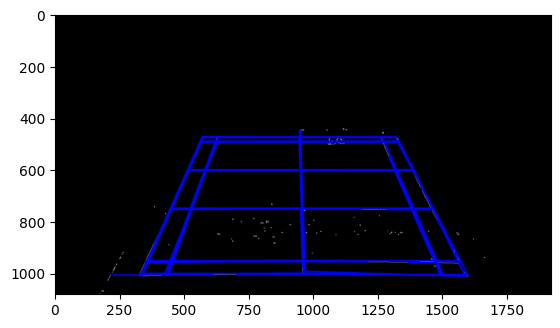

In [249]:
# img_sng_list = [single_image_preprocess(img, mask_sng) for filename, img in images_single[:5]]

# lines_sng_set = [hough_line(img,2)[1] for img in img_sng_list]

# edges = hough_line(img_sng_list[0], 2)[0]

img_sng=single_image_preprocess(res_sng,mask_sng)
plt.imshow(res_sng)
lines_sng=hough_line(img_sng,2)[1]
edges=hough_line(img_sng,2)[0]

In [250]:
centers_sng = find_centers([lines_sng], 35)
# centers = find_centers(lines_set, 30)

[[1594.2781  1003.09094]
 [ 449.5932   954.5455 ]
 [1314.5068   602.     ]
 [ 960.30756  954.5455 ]
 [ 620.8444   492.00003]
 [ 948.1296   602.     ]
 [1376.0427   750.7143 ]
 [ 448.1969   750.7143 ]
 [1488.1146  1003.09094]
 [1257.6567   474.     ]
 [ 357.37567  954.5455 ]
 [ 953.26666  750.7143 ]
 [ 943.70807  474.00003]
 [ 525.059    750.7143 ]
 [ 514.45966  602.     ]
 [1568.5087   954.5455 ]
 [ 580.1185   602.     ]
 [1459.2809   750.7143 ]
 [ 431.61993 1003.0909 ]
 [ 961.98456 1003.0909 ]
 [1317.0302   474.     ]
 [1475.617    954.5455 ]
 [1382.8312   602.     ]
 [ 335.74515 1003.09094]
 [ 563.4725   492.     ]
 [1326.2834   492.     ]
 [ 944.3298   492.00003]
 [1385.0717   750.7143 ]
 [1581.1332  1003.09094]
 [ 627.5088   474.00003]
 [ 571.4928   474.     ]
 [1265.6514   492.     ]
 [1466.5575   954.5455 ]
 [1497.1821  1003.09094]
 [1557.398    954.5455 ]]


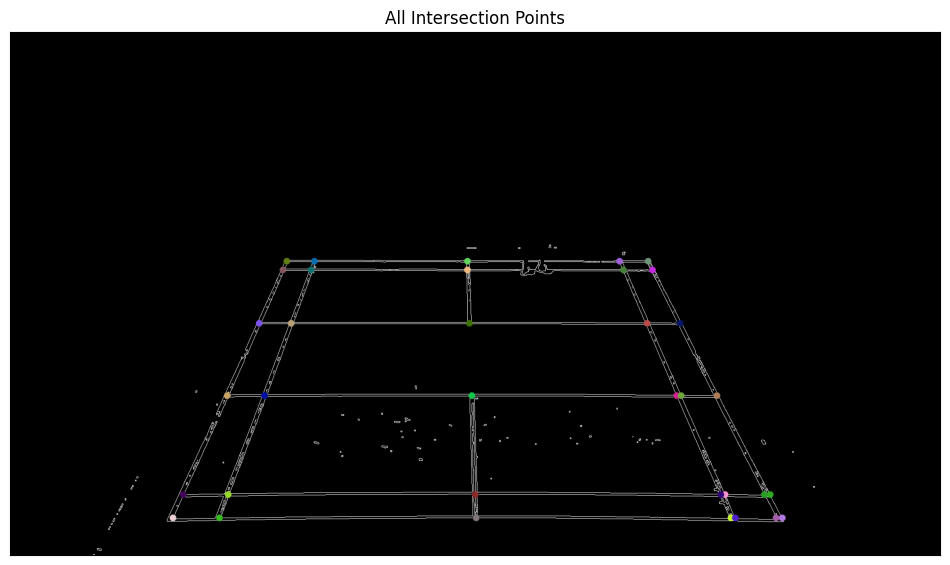

In [251]:
intersectsimg = edges.copy()
intersectsimg = cv2.cvtColor(intersectsimg, cv2.COLOR_GRAY2BGR) 
print(centers_sng)
for cx, cy in centers_sng:
    cx = np.round(cx).astype(int)
    cy = np.round(cy).astype(int)
    color = np.random.randint(0,255,3).tolist() # random colors
    cv2.circle(intersectsimg, (cx, cy), radius=7, color=color, thickness=-1) # -1: filled circle

plt.figure(figsize=(12,8)) 
plt.imshow(intersectsimg, cmap='magma') 
plt.title('All Intersection Points'), plt.xticks([]), plt.yticks([])
plt.show()

[array([571, 474], dtype=int32), array([627, 474], dtype=int32), array([943, 474], dtype=int32), array([1257,  474], dtype=int32), array([1317,  474], dtype=int32)]


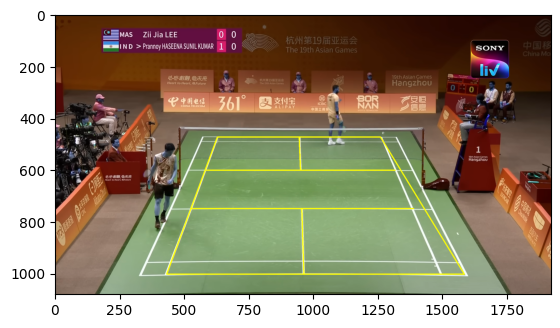

In [252]:
# print(sort_centers(centers_sng)[-1])
image = images_single[0][1].copy()
centres_sorted=sort_centers(centers_sng)

centres_sorted_filtered=np.array([row for row in centres_sorted if len(row)>=5], dtype=object)

print(centres_sorted[0])

img = draw_single_court(image, centres_sorted_filtered)

plt.imshow(img)